## Desigualdade De Bell
- desigualdade de CHSH estabelece um limite máximo para a correlação entre medições locais em dois sistemas separados
- Limite Clássico: $|S|\leq2$
- Limite Quântico: $|S|\leq2\sqrt{2}$

## Desenvolvendo um circuito para Violar a Desigualdade de Bell

1. Preparar um estado maximamente emaranhado
2. Realizar medições nos qubits em bases escolhidas para maximizar a violação da desigualdade de Bell
3. Coletar as estatísticas 
4. Calcular a expressão de CHSH com os resultados experimentais.

In [2]:
from qiskit import *
from qiskit.circuit.library import RYGate
import numpy as np
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, DensityMatrix

## Mapeamento:
- Criação do circuito com qubtis emaranhados
- Para violar CHSH, as medições devem ser feitas em bases rotacionadas. Logo, vamo aplicar uma porta RY para atingir a violação.


In [3]:
#Função do estado de bell com parametros theta_a e theta_b
def bell_circuit(theta_a, theta_b):
    qc = QuantumCircuit(2, 2)
    qc.h(0)
    qc.cx(0, 1)
    qc.x(1)
    qc.z(1)
    
    #Rotação de um qubit em torno do eixo Y.
    qc.ry(-2 * theta_a, 0) #Rotação de Alice
    qc.ry(-2 * theta_b, 1) #Rotação de Bob
    
    qc.measure_all()
    return qc

# Circuito sem rotação
theta_a = 0
theta_b = 0

circuito = bell_circuit(theta_a, theta_b)
print(circuito.draw())

        ┌───┐     ┌───────┐               ░ ┌─┐   
   q_0: ┤ H ├──■──┤ Ry(0) ├───────────────░─┤M├───
        └───┘┌─┴─┐└─┬───┬─┘┌───┐┌───────┐ ░ └╥┘┌─┐
   q_1: ─────┤ X ├──┤ X ├──┤ Z ├┤ Ry(0) ├─░──╫─┤M├
             └───┘  └───┘  └───┘└───────┘ ░  ║ └╥┘
   c: 2/═════════════════════════════════════╬══╬═
                                             ║  ║ 
meas: 2/═════════════════════════════════════╩══╩═
                                             0  1 


In [4]:
psi = Statevector(circuito)
DensityMatrix(psi)

QiskitError: 'Cannot apply instruction with classical bits: measure'

## Criação do Backend e Transpilação 
1. Criamos o Backend e definimos a quantidade de execuções
2. Execução de circuitos para ângulos específicos
3. Executar cada circuito para uma das quatro configurações.
4. Loop:
    - Simular quatro experimentos diferentes com quatro ângulos
    - Salva os resultados 

In [5]:
backend = AerSimulator()
shots = 260

# Ângulos para cada configuração
angles = {
    'A0B0': (0,np.pi+np.pi/4),
    'A0B1': (0,np.pi+np.pi/2+np.pi/4),
    'A1B0': (-np.pi/4, np.pi+np.pi/4),
    'A1B1': (-np.pi/4, np.pi+np.pi/2+np.pi/4)
}

# Executar os circuitos
results = {}
for label, (theta_a, theta_b) in angles.items(): # #dicionário onde cada chave representa uma combinação de configurações de medição
    qc = bell_circuit(theta_a, theta_b) #Retorna o circuito quântico específico daquela configuração.
    tqc = transpile(qc, backend) #adapta o circuito para o backend (aqui, o simulador).
    job = backend.run(tqc, shots=shots) #Executa o circuito transpilado no simulador.
    counts = job.result().get_counts()
    results[label] = counts #Armazena os resultados no dicionário results, com a chave sendo o rótulo da configuração

5.  Calcular o valor esperado

$$
E = \sum_{a,b} v(a,b) \cdot P(a,b)
\quad \text{onde} \quad
v(a,b) = 
\begin{cases}
+1 & \text{se } a = b \\
-1 & \text{se } a \neq b
\end{cases}
$$

In [6]:
def expectation(counts):
    total = sum(counts.values())
    e = 0
    for outcome, count in counts.items():
        a, b = int(outcome[1]), int(outcome[0])  # Qiskit: bit 0 é o último
        value = 1 if a == b else -1
        e += value * count / total
    return e


## Cálculo do parâmetro CHSH
$$
S =E(A_0,B_0)+E(A_0,B_1)+E(A_1,B_0)-E(E_1,B_1)
$$
- Se 
$∣S∣>2$, há violação da desigualdade clássica, provando não-localidade quântica.

In [7]:
E = {label: expectation(c) for label, c in results.items()}

S = E['A0B0'] + E['A0B1'] + E['A1B0'] - E['A1B1']
print(f"S = {S:.3f}")


S = 2.092


In [8]:
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

## Interpretação dos histogramas: 
| Resultado | Interpretação   | Contribuição para $E$ | Correlação|
| --------- | --------------- | --------------------- | --------- |
| `'00'`    | Ambos mediram 0 | $+1$                  | Forte     |
| `'11'`    | Ambos mediram 1 | $+1$                  | Forte     |
| `'01'`    | Alice 0, Bob 1  | $-1$                  | Anticorrelação|
| `'10'`    | Alice 1, Bob 0  | $-1$                  | Anticorrelação|

- Se $P(00)+P(11)≫P(01)+P(10)$, o valor esperado é próximo de +1: Correlacionado ($\ket{00} e \ket{11}$)
- Se $P(00)+P(11)<<P(01)+P(10)$, o valor esperado é proximo de -1: Anticorrelacionado($\ket{10} e \ket{01}$)
- Se $P(00)=P(11)==P(01)==(10)$, o valor esperado é zero: sem correlação.



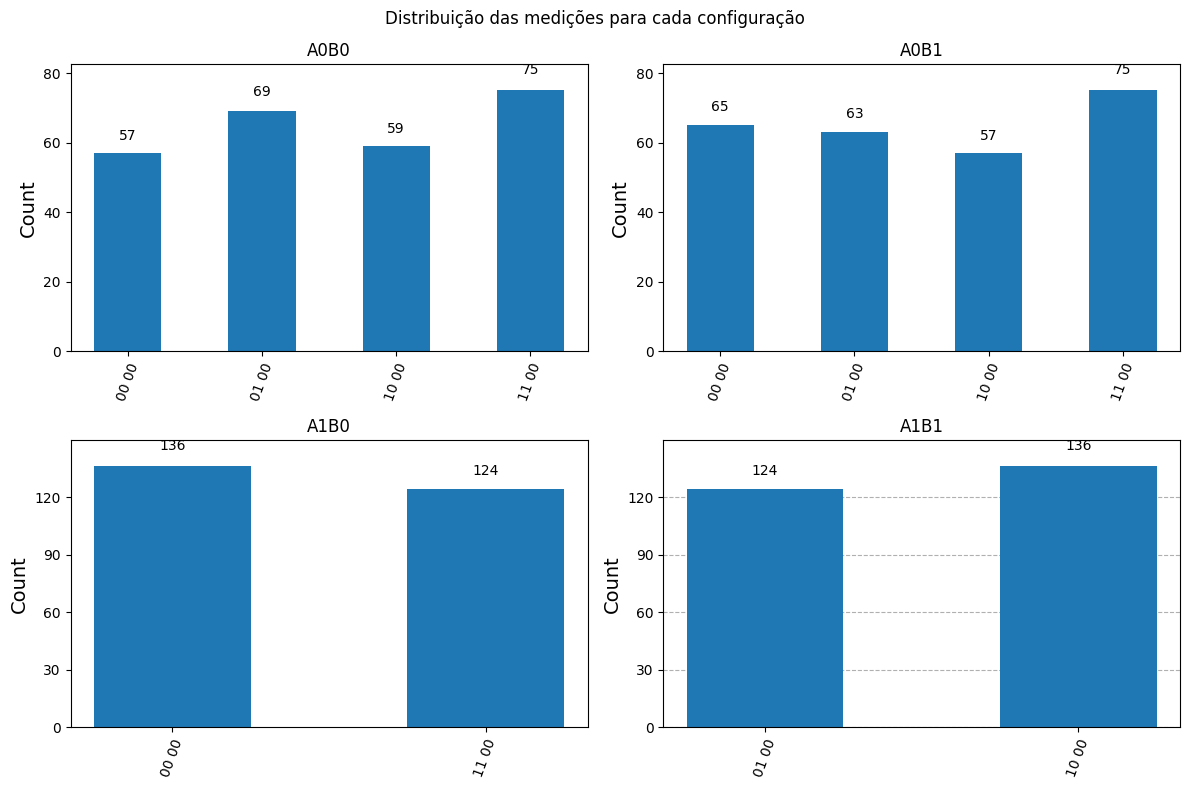

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
labels = list(results.keys())

for i, ax in enumerate(axs.flat):
    plot_histogram(results[labels[i]], ax=ax)
    ax.set_title(labels[i])

plt.suptitle("Distribuição das medições para cada configuração")
plt.tight_layout()
plt.show()
